In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import concatenate as concat
import numpy as np
from model.vae.vae_fashionmnist import VariationalAutoEncoderMNIST
from util.experiment import Experiment, load_experiments
from util.plotting import plot_label_clusters
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from collections import OrderedDict
import copy

# Interactive tools
from pathlib import Path
from PIL import Image
import pickle
import numpy as np

import ipywidgets as widgets
from tqdm import tqdm

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(_, _), (valid_images, valid_labels) = fashion_mnist.load_data()
valid_images = valid_images.astype("float32") / 255.0
valid_images = tf.expand_dims(valid_images, axis=-1)

class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

2022-06-28 16:04:58.764999: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
RUN_NAME = "branchedClassifier"
#MODEL_NAME = "1416_speak-leave-easy-money"
MODEL_NAME = "1402_die-continue-entire-room"
EXAMPLE_IMAGE = tf.expand_dims(valid_images[7], axis=0)

In [4]:
experiment = Experiment(name=MODEL_NAME, base_path="experiments/"+RUN_NAME)
base_model = experiment.load_model()
params = {'input_dim': (28, 28, 1), 'z_dim': experiment.params['latent_dim'], 'beta': experiment.params['beta']}
model = VariationalAutoEncoderMNIST.from_saved_model(base_model, params)
model.compile()

print(experiment.params)

{'optimizer': 'Adam', 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'latent_dim': 4, 'beta': 8}


# Setup

## Interactive Traversal

In [5]:
def forward_pass(img):
    z_mean, z_log_var, _ = model.encode(img)
    z = model.reparameterize(z_mean, z_log_var)
    
    reco = model.decode(z)
    reco = tf.sigmoid(reco)
    
    return z_mean, z_log_var, z, reco

# Forward pass
z_mean, z_log_var, z, reco = forward_pass(EXAMPLE_IMAGE)
stddev = 2*tf.exp(z_log_var)
reco_img = plt.cm.Greys(reco.numpy().squeeze(), bytes=True)
z_tmp = copy.deepcopy(z.numpy())

In [6]:
def decode_latent_dims(btn):
    image_output = CONTROLLER.children[0]
    dim_sliders_box = CONTROLLER.children[1]
    dim_sliders = dim_sliders_box.children[:-2]
    
    dim_changes = [(i, x.children[0].value) for i, x in enumerate(dim_sliders)]
    
    for dim, amount in dim_changes:
        #print(z_tmp[0][dim], amount)
        z_tmp[0][dim] = amount
        
    reco_tmp = model.decode(z_tmp)
    reco_tmp = plt.cm.Greys(reco_tmp.numpy().squeeze(), bytes=True)
    rec_output = image_output.children[0]
    with rec_output:
        rec_output.clear_output(wait=True)
        rec_img = Image.fromarray(reco_tmp)
        display(rec_img.resize((250, 250), Image.Resampling.LANCZOS))
    
def reset_latent_dims(btn):
    image_output = CONTROLLER.children[0]
    dim_sliders_box = CONTROLLER.children[1]  
    
    rec_output = image_output.children[0]
    with rec_output:
        rec_output.clear_output(wait=True)
        rec_img = Image.fromarray(reco_img)
        display(rec_img.resize((250, 250), Image.Resampling.LANCZOS))
    
    dim_sliders = dim_sliders_box.children[:-2]
    for dim, slider in enumerate(dim_sliders):
        slider.children[0].value = z[0][dim]

In [7]:
rec_output = widgets.Output()
with rec_output:
    rec_output.clear_output()
    rec_img = Image.fromarray(reco_img)
    display(rec_img.resize((250, 250), Image.Resampling.LANCZOS))

image_output = widgets.VBox([rec_output])

decode_btn = widgets.Button(description="Decode", layout=widgets.Layout(width='75%', height='10%'))
decode_btn.on_click(decode_latent_dims)

reset_btn = widgets.Button(description="Reset", layout=widgets.Layout(width='75%', height='10%'))
reset_btn.on_click(reset_latent_dims)

dim_sliders = []
for dim in range(0, experiment.params['latent_dim']):
    label = widgets.Label("z%d" % dim)
    slider = widgets.FloatSlider(min=z_mean[0][dim]-tf.abs(stddev[0][dim]), max=z_mean[0][dim]+tf.abs(stddev[0][dim]), value=z_tmp[0][dim], step=0.05, continuous_update=False)
    slider.observe(decode_latent_dims)
    dim_sliders.append(widgets.HBox([slider, label]))

dim_sliders.append(decode_btn)
dim_sliders.append(reset_btn)

dim_sliders_box = widgets.VBox(dim_sliders)

CONTROLLER = widgets.HBox([image_output, dim_sliders_box])
print(z_tmp)
print(z_mean)
print(stddev)
print(z_log_var)

[[-0.25974718 -0.77319336 -0.5037879   0.48755044]]
tf.Tensor([[ 0.04724329  0.16740087 -0.21906191  0.05466757]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.14595881 1.3163592  1.4096859  0.17209205]], shape=(1, 4), dtype=float32)
tf.Tensor([[-2.617578   -0.41827753 -0.34978032 -2.452873  ]], shape=(1, 4), dtype=float32)


## SPM

In [8]:
import plotly.express as px

z_mean, _, _ = model.encoder(valid_images[:3000])
train_labels_decoded = [class_names[i] for i in valid_labels[:3000]]
labels_df = pd.DataFrame(train_labels_decoded, columns = ['class'])
cols = ['z'+str(i) for i in range(0, z_mean.shape[1])]
z_df = pd.DataFrame(z_mean, columns=cols)
labeled_z_df = pd.concat([labels_df, z_df], axis=1)

SPM = px.scatter_matrix(labeled_z_df, dimensions=cols, color="class", title="Scatter plot matrix of latent dimensions")
SPM = SPM.update_layout(
    dragmode='select',
    width=800,
    height=800,
)

# Dashboard

## Inline

In [9]:
CONTROLLER

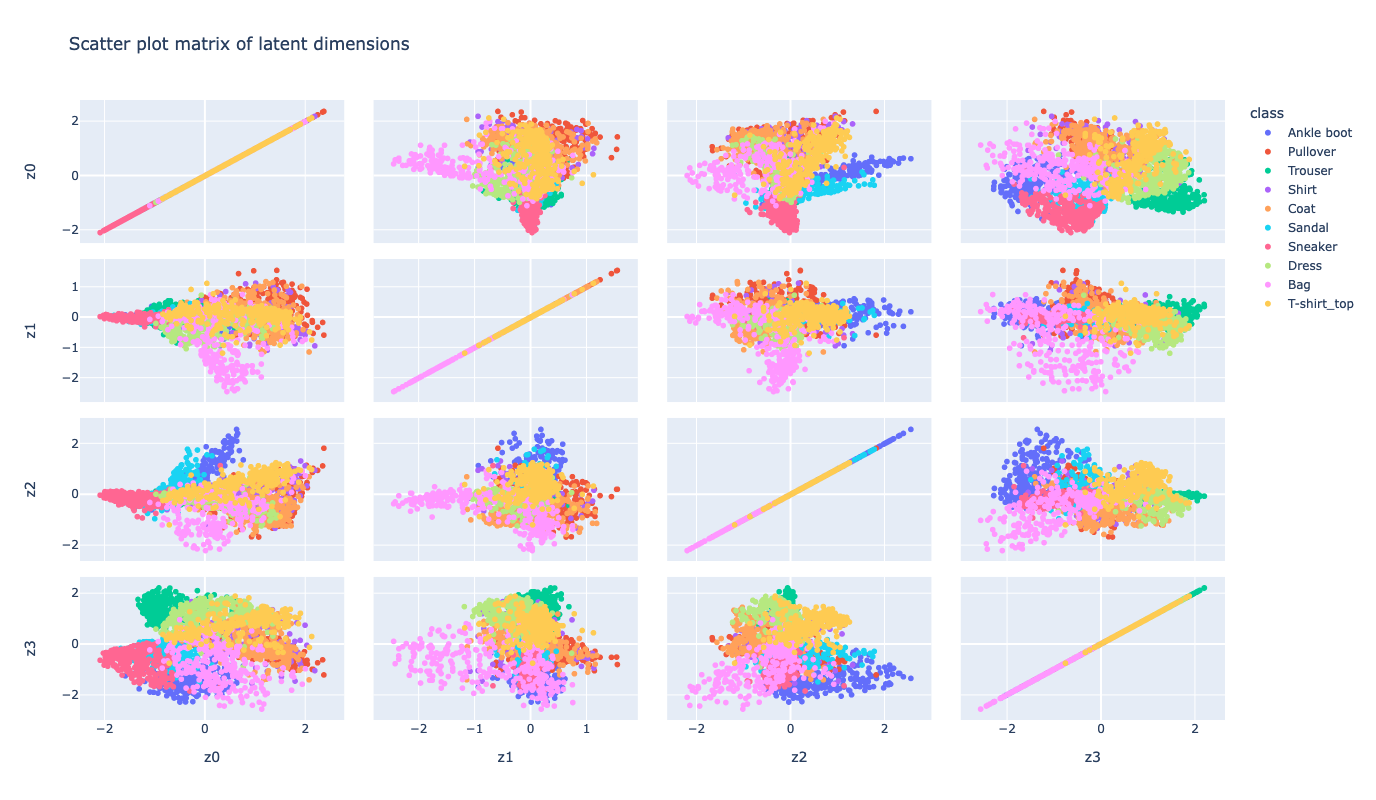

In [10]:
SPM.show()

## Dash

In [11]:
import base64
import dash
import dash_core_components as dcc
import dash_html_components as html
from PIL import Image
from io import BytesIO
from sklearn.decomposition import PCA
from dash.dependencies import Input, Output


def NamedSlider(name, short, style, min, max, step, val):
    #marks = {i: np.round(val, 2) for i, val in enumerate(steps)}

    return html.Div(
        style=style,
        children=[
            f"{name}:",
            html.Div(
                style={"margin-left": "5px"},
                children=[
                    dcc.Slider(
                        id=f"slider-{short}",
                        min=min,
                        max=max,
                        step=step,
                        value=val,
                        marks=None,
                        tooltip={"placement": "bottom", "always_visible": True}
                    )
                ],
            ),
        ],
    )


def generate_dim_sliders(visible, values=None):
    sliders = []
    for dim in range(0, experiment.params['latent_dim']):
        if dim <= visible-1:
            hide = False
        else:
            hide = True
            
        sliders.append(
            NamedSlider(
                name=f"z{dim+1}",
                short=f"z{dim+1}",
                style={"display": "none"} if hide else {"margin": "25px 5px 30px 0px"},
                min=z_mean[0][dim]-tf.abs(stddev[0][dim]),
                max=z_mean[0][dim]+tf.abs(stddev[0][dim]),
                step=0.05,
                val=values[dim] if values is not None and not hide else 0
            )
        )
    return sliders


def numpy_to_b64(array, upscale=True, scalar=True):
    # Convert from 0-1 to 0-255
    if scalar:
        array = np.uint8(255 * array)

    im_pil = Image.fromarray(array)
    if upscale:
        im_pil = im_pil.resize((250, 250), Image.Resampling.LANCZOS)
    
    buff = BytesIO()
    im_pil.save(buff, format="png")
    im_b64 = base64.b64encode(buff.getvalue()).decode("utf-8")

    return im_b64

/var/folders/bz/z6j3rgzx6kjcvd1jjr276s9c0000gn/T/ipykernel_93057/3671225720.py:3: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

/var/folders/bz/z6j3rgzx6kjcvd1jjr276s9c0000gn/T/ipykernel_93057/3671225720.py:4: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



In [12]:
title = "Latent Space Visualization"
shown_dims = experiment.params['latent_dim']

app = dash.Dash(__name__)
app.title = title
app.layout = html.Div(children=[
    html.H2(title),
    # Scatter Plot Matrix, left column
    html.Div(children=[
        #dcc.Graph(figure=SPM),
        dcc.Graph(id="spm-graph"),
        html.P("Number of components:"),
        dcc.Slider(id='pca-slider', min=2, max=experiment.params['latent_dim'], value=experiment.params['latent_dim'], step=1),
    ], style={'padding': 10, 'flex': 1}),
    
    # Reconstructed image, right column
    html.Div(children=[
        html.Div(
            id="reconstruction-message-div",
            style={
                "text-align": "center",
                "margin-bottom": "7px",
                "font-weight": "bold",
            },
            children=[html.H4("Select a sample")]
        ),
        html.Div(id="reconstruction-image-div"),
        html.Div(id="z-slider-div", children=generate_dim_sliders(0)),
        
    ], style={'padding': 10, 'flex': 1}),
], style={'display': 'flex', 'flex-direction': 'row'})


# PCA Slider callback
@app.callback(
    Output("spm-graph", "figure"),
    Input("pca-slider", "value")
)
def run_and_plot(n_components):
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(z_df)
    var = pca.explained_variance_ratio_.sum() * 100

    labels = [f"PC {i+1}" for i in range(n_components)]

    components_df = pd.DataFrame(components, columns=labels)
    components_labeled_df = pd.concat([labels_df, components_df], axis=1)
    
    fig = px.scatter_matrix(
        components_labeled_df, 
        dimensions=labels, 
        color="class", 
        title=f'Total Explained Variance: {var:.2f}%'
    )
    fig.update_layout(
        width=800,
        height=800,
    )
    fig.update_traces(diagonal_visible=False)
    return fig


@app.callback(
    Output("reconstruction-image-div", "children"),
    [Input("pca-slider", "value")] + [Input(f"slider-z{dim+1}", "value") for dim in range(0, experiment.params['latent_dim'])]
)
def decode_z_sliders(n_components, *args):
    if len(args) >= 2:
        pca = PCA(n_components=n_components)
        components = pca.fit_transform(z_df)

        z = pca.inverse_transform([val for val in args[:n_components]])
        z_transformed = tf.expand_dims(z, axis=0)

        # Decode
        reco_z = model.decode(z_transformed)
        reco_z = plt.cm.Greys(reco_z.numpy().squeeze(), bytes=True)
        print(reco_z)
        image_b64 = numpy_to_b64(reco_z, upscale=True, scalar=False)
        return html.Img(
            src="data:image/png;base64, " + image_b64,
            style={"height": "25vh", "display": "block", "margin": "auto"},
        )
    return None


# SPM click callback
@app.callback(
    [
        Output("z-slider-div", "children"),
        Output("reconstruction-message-div", "children")
    ],
    [
        Input("spm-graph", "clickData"),
        Input("pca-slider", "value")
    ]
)
def fill_z_sliders(clickData, value):
    if clickData:
        point = np.array([clickData["points"][0][f"dimensions[{i}].values"] for i in range(0, value)]).astype(np.float32)
        return generate_dim_sliders(value, values=point), None
        
    return None, html.H4("Select a sample")

In [ ]:
app.run_server(debug=True, use_reloader=False, port="8080")

Dash is running on http://127.0.0.1:8080/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
[[[255 255 255 255]
  [254 254 254 255]
  [254 254 254 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[254 254 254 255]
  [255 255 255 255]
  [254 254 254 255]
  ...
  [255 255 255 255]
  [254 254 254 255]
  [255 255 255 255]]

 [[254 254 254 255]
  [254 254 254 255]
  [253 253 253 255]
  ...
  [253 253 253 255]
  [253 253 253 255]
  [254 254 254 255]]

 ...

 [[254 254 254 255]
  [253 253 253 255]
  [250 250 250 255]
  ...
  [247 247 247 255]
  [250 250 250 255]
  [253 253 253 255]]

 [[254 254 254 255]
  [253 253 253 255]
  [250 250 250 255]
  ...
  [248 248 248 255]
  [250 250 250 255]
  [253 253 253 255]]

 [[254 254 254 255]
  [255 255 255 255]
  [254 254 254 255]
  ...
  [253 253 253 255]
  [253 253 253 255]
  [254 254 254 255]]]
[[[255 255 255 255]
  [254 254 254 255]
  [254 254

In [ ]:
a = [1, 2, 3]

In [ ]:
a[:2]